## University Ranking Predictions

In [579]:
%matplotlib inline
import pandas as pd
import numpy as np
shanghai_data_full = pd.read_csv("data/shanghaiData.csv")
shanghai_data_full = shanghai_data_full[shanghai_data_full.total_score.notnull()]
shanghai_data_full.head()

,world_rank,university_name,national_rank,total_score,alumni,award,hici,ns,pub,pcp,year
0,1,Harvard University,1,100.0,100.0,100.0,100.0,100.0,100.0,72.4,2005
1,2,University of Cambridge,1,73.6,99.8,93.4,53.3,56.6,70.9,66.9,2005
2,3,Stanford University,2,73.4,41.1,72.2,88.5,70.9,72.3,65.0,2005
3,4,"University of California, Berkeley",3,72.8,71.8,76.0,69.4,73.9,72.2,52.7,2005
4,5,Massachusetts Institute of Technology (MIT),4,70.1,74.0,80.6,66.7,65.8,64.3,53.0,2005


## Split to Training and Test

In [580]:
names_full = shanghai_data_full['university_name'][0:100]
rows = np.random.choice(names_full.index.values, 20)
names_test = names_full.ix[rows]
names = names_full.drop(rows)

In [581]:
shanghai_data_test = shanghai_data_full[shanghai_data_full.university_name.isin(names_test)]
shanghai_data = shanghai_data_full[shanghai_data_full.university_name.isin(names)]

features_with_name = ['total_score', 'university_name', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'pub', 'pcp', 'year']
prediction_data_test = shanghai_data_test.loc[:,features_with_name]
prediction_data = shanghai_data.loc[:,features_with_name]

## Scaling Features

In [582]:
from sklearn.preprocessing import StandardScaler

to_predict = ['total_score', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'hici', 'pub', 'pcp']
scaler = StandardScaler()
scaler.fit(prediction_data.loc[:,to_predict])
#prediction_data.loc[:,to_predict] = scaler.transform(prediction_data.loc[:,to_predict])
#prediction_data_test.loc[:,to_predict] = scaler.transform(prediction_data_test.loc[:,to_predict])
prediction_data.head()

,total_score,university_name,national_rank,alumni,award,hici,ns,pub,pcp,year
1,73.6,University of Cambridge,1,99.8,93.4,53.3,56.6,70.9,66.9,2005
2,73.4,Stanford University,2,41.1,72.2,88.5,70.9,72.3,65.0,2005
3,72.8,"University of California, Berkeley",3,71.8,76.0,69.4,73.9,72.2,52.7,2005
4,70.1,Massachusetts Institute of Technology (MIT),4,74.0,80.6,66.7,65.8,64.3,53.0,2005
5,67.1,California Institute of Technology,5,59.2,68.6,59.8,65.8,52.5,100.0,2005


## Using Multiple Past Years

In [583]:
years_back = 4
to_predict = ['total_score', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'hici', 'pub', 'pcp', 'year']
for index, row in prediction_data.iterrows():
    is_complete = True
    current_row = prediction_data[(prediction_data.university_name == row.university_name) & (prediction_data.year == row.year)]
    past_rows = {}
    for year in range(1, years_back+1):
        past_row = prediction_data[(prediction_data.university_name == row.university_name) & (prediction_data.year == row.year-year)]
        past_rows[year] = past_row
        if len(past_row.values) == 0:
            is_complete = False
    
    if (is_complete):
        prediction_data.loc[index, 'score_relative'] = (float(current_row['total_score'].values[0]) - float(past_row['total_score'].values[0]))
        
        for year in range(1, years_back+1):
            past_row = past_rows[year]
            for feature in to_predict:
                prediction_data.loc[index, feature + '_back_' + str(year)] = float(past_row[feature].values[0])

complete_filter = prediction_data.apply(lambda row : np.isnan(row['total_score_back_' + str(years_back)]),axis=1) 
prediction_data_clean = prediction_data[~complete_filter]
prediction_data_clean.head()

,total_score,university_name,national_rank,alumni,award,hici,ns,pub,pcp,year,...,year_back_3,total_score_back_4,national_rank_back_4,alumni_back_4,award_back_4,hici_back_4,ns_back_4,pub_back_4,pcp_back_4,year_back_4
2014,73.1,Stanford University,2,39.0,78.7,87.1,67.3,70.1,66.9,2009,...,2006.0,73.4,2.0,41.1,72.2,88.5,70.9,72.3,65.0,2005.0
2015,71.0,"University of California, Berkeley",3,67.4,77.1,68.4,71.1,69.0,53.2,2009,...,2006.0,72.8,3.0,71.8,76.0,69.4,73.9,72.2,52.7,2005.0
2016,70.2,University of Cambridge,1,89.4,91.5,53.8,53.9,65.4,65.5,2009,...,2006.0,73.6,1.0,99.8,93.4,53.3,56.6,70.9,66.9,2005.0
2017,69.5,Massachusetts Institute of Technology (MIT),4,71.0,80.6,65.7,67.9,62.0,54.4,2009,...,2006.0,70.1,4.0,74.0,80.6,66.7,65.8,64.3,53.0,2005.0
2018,64.8,California Institute of Technology,5,51.5,69.1,57.1,66.2,47.7,100.0,2009,...,2006.0,67.1,5.0,59.2,68.6,59.8,65.8,52.5,100.0,2005.0


In [584]:
#prediction_data_clean.loc[:,['total_score', 'total_score_back_1', 'total_score_back_2', 'score_relative']]

## Dont Modify `prediction_data_clean` From Here 

In [585]:
features = []
for feature in to_predict:
    for year in range(1, years_back+1):
        features.append(feature + '_back_' + str(year))

In [596]:
X = prediction_data_clean.loc[:,features]

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
clf_map = {}
# Just going to use Linear for now to save time
# Don't know how to split training set properly here to save test set
# Can we score ourself with a few iterations down the line?
to_predict_without_total = ['national_rank', 'alumni', 'award', 'hici', 'ns', 'hici', 'pub', 'pcp', 'year']
for feature in to_predict:
    clf = LinearRegression()
    y = np.ravel(prediction_data_clean.loc[:,[feature]])
    clf.fit(X, y)
    clf_map[feature] = clf
    cv_scores = cross_val_score(clf, X, y, cv=4)
    print (cv_scores)
    
y = np.ravel(prediction_data_clean.loc[:,['score_relative']])
clf.fit(X, y)
clf_map['score_relative'] = clf
cv_scores = cross_val_score(clf, X, y, cv=4)
print (cv_scores)

[ 0.99610056  0.99602036  0.99708412  0.99065888]
[ 0.99409293  0.99656426  0.99649887  0.99294604]
[ 0.98861713  0.94765198  0.98664267  0.98607298]
[ 0.99619548  0.99352666  0.9898553   0.99136175]
[ 0.99227723  0.98617333  0.98949854  0.9284991 ]
[ 0.98254375  0.98732234  0.98360565  0.91246064]
[ 0.99227723  0.98617333  0.98949854  0.9284991 ]
[ 0.98946902  0.98342127  0.98330661  0.98567532]
[ 0.86019834  0.94747539  0.97286259  0.96779699]
[ 1.  1.  1.  1.]
[ 0.77023831  0.7674014   0.7614388   0.56421173]


## Make Prediction Code Reuseable

In [587]:
import seaborn as sb
import matplotlib.pyplot as plt

[-2.02488958]
[ 24.40928558]
[ 75.78632939]
[ 178.57887762]
[ 355.16352268]


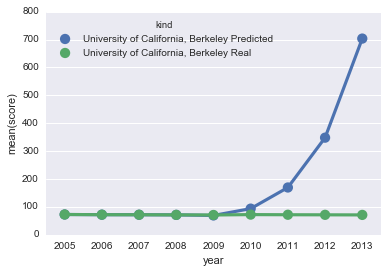

In [597]:
def get_school_graph_data(school_name_to_predict):
    university_data = prediction_data_clean[(prediction_data_clean.university_name == school_name_to_predict) & (prediction_data_clean.year == (2005 + years_back))]
    X = university_data.loc[:,features]
    start_scores = X['total_score_back_' + str(years_back)].values
    for i in range(1, years_back):
        start_scores = np.append(start_scores, X['total_score_back_' + str(years_back-i)].values)

    real_scores = prediction_data_clean[prediction_data_clean.university_name == school_name_to_predict]['total_score'].values
    real_scores = np.append(start_scores, real_scores)
    
    predicted_scores = start_scores.copy()
    X_continue = X.copy()
    for i in range(len(real_scores) - years_back):
        X_original = X_continue.copy()
        for feature in to_predict:
            X_continue[feature + '_back_1'] = clf_map[feature].predict(X_original)
            for i in range(1, years_back):
                X_continue[feature + '_back_' + str(i + 1)] = X_original[feature + '_back_' + str(i)]
        
        score_relative = clf_map['score_relative'].predict(X_original)
        print (score_relative)
        X_continue['total_score_back_1'] = X_original['total_score_back_1'] + score_relative
        predicted_scores = np.append(predicted_scores, X_continue['total_score_back_1'].values)
        for i in range(1, years_back):
            X_continue['total_score_back_' + str(i + 1)] = X_original['total_score_back_' + str(i)]

    end_year = 2005 + len(real_scores)
    years = np.array(range(2005, end_year))
    predicted = pd.DataFrame({ 'score' : predicted_scores, 'year' : years })
    real = pd.DataFrame({ 'score' : real_scores, 'year' : years })
    predicted['kind'] = school_name_to_predict + ' Predicted'
    real['kind'] = school_name_to_predict + ' Real'
    graph_data = predicted.append(real)
    return graph_data

school_name_to_predict = ['University of California, Berkeley']
graph_data = get_school_graph_data(school_name_to_predict[0])
graph = sb.pointplot(x='year', y='score', hue='kind', data=graph_data)

In [589]:
def plot_scores_by_names(universities_to_plot):
    graph_data = pd.DataFrame()
    num_universitites = len(universities_to_plot)
    linestyles = ["-", "--"]*num_universitites
    markers= ["o", "x"]*num_universitites
    palette = np.repeat(sb.color_palette("Set1", n_colors=num_universitites, desat=.5), 2, axis=0)

    for name in universities_to_plot:
        graph_data = graph_data.append(get_school_graph_data(name))
    fig, (ax) = plt.subplots(1,1, figsize=(20,10))
    sb.pointplot(x='year', y='score', hue='kind', linestyles=linestyles, markers=markers, palette=palette, data=graph_data, ax=ax)

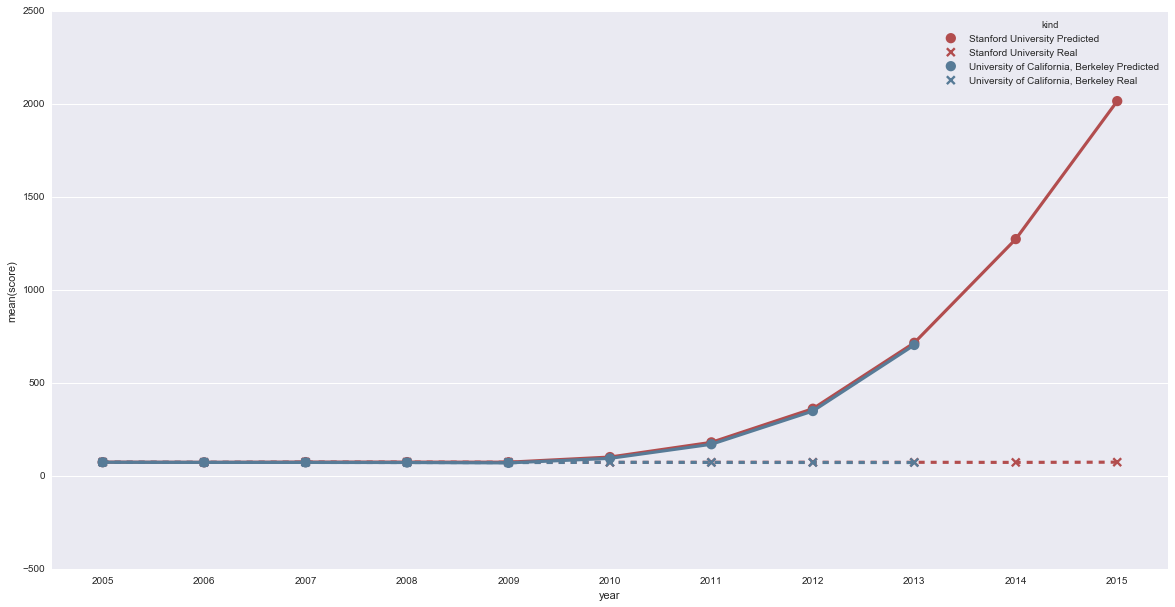

In [590]:
plot_scores_by_names(shanghai_data[1:3]['university_name'].values)

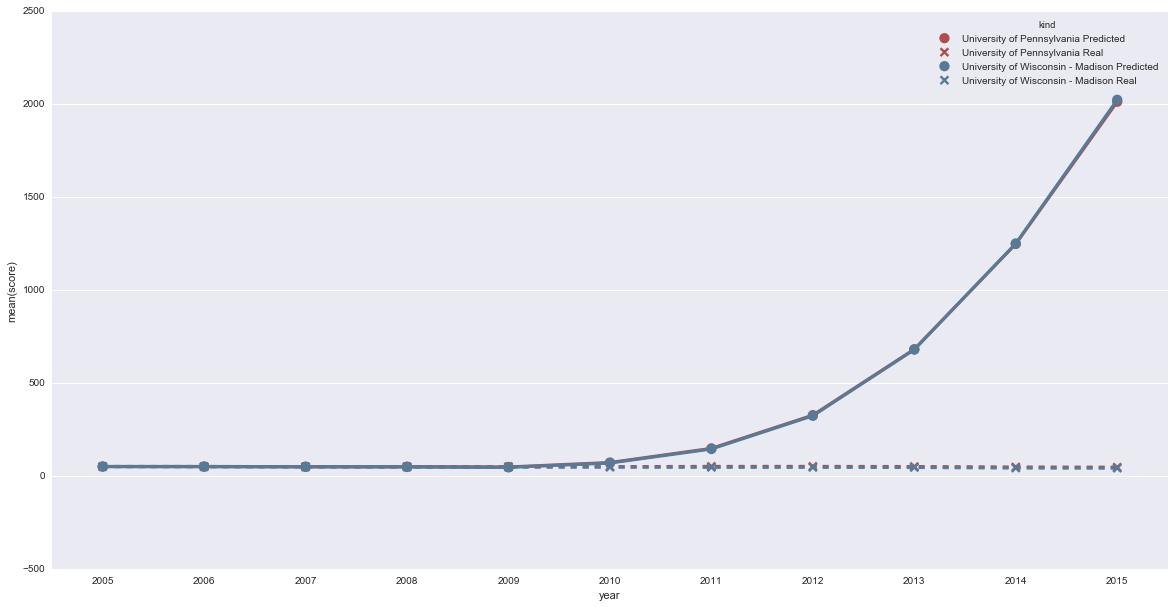

In [591]:
plot_scores_by_names(shanghai_data[11:13]['university_name'].values)

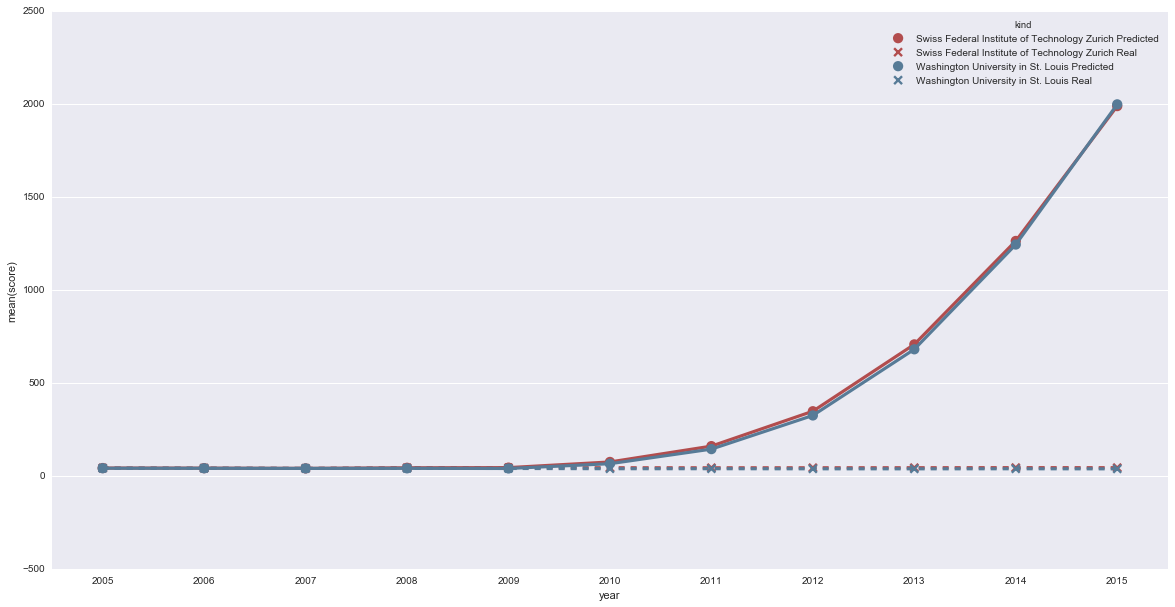

In [592]:
plot_scores_by_names(shanghai_data[21:23]['university_name'].values)

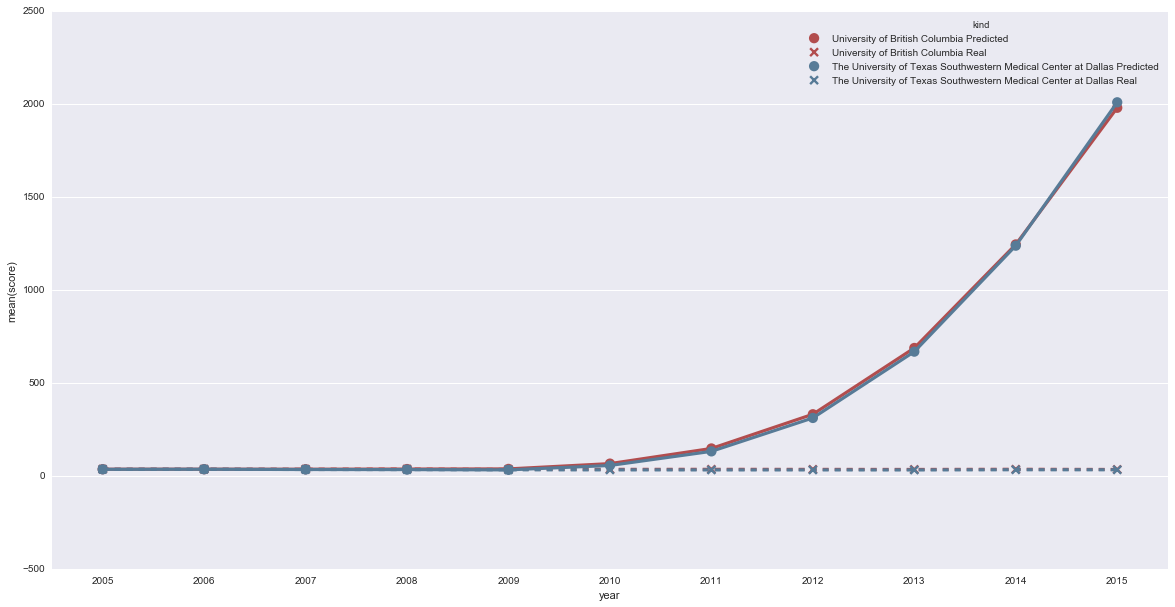

In [593]:
plot_scores_by_names(shanghai_data[31:33]['university_name'].values)

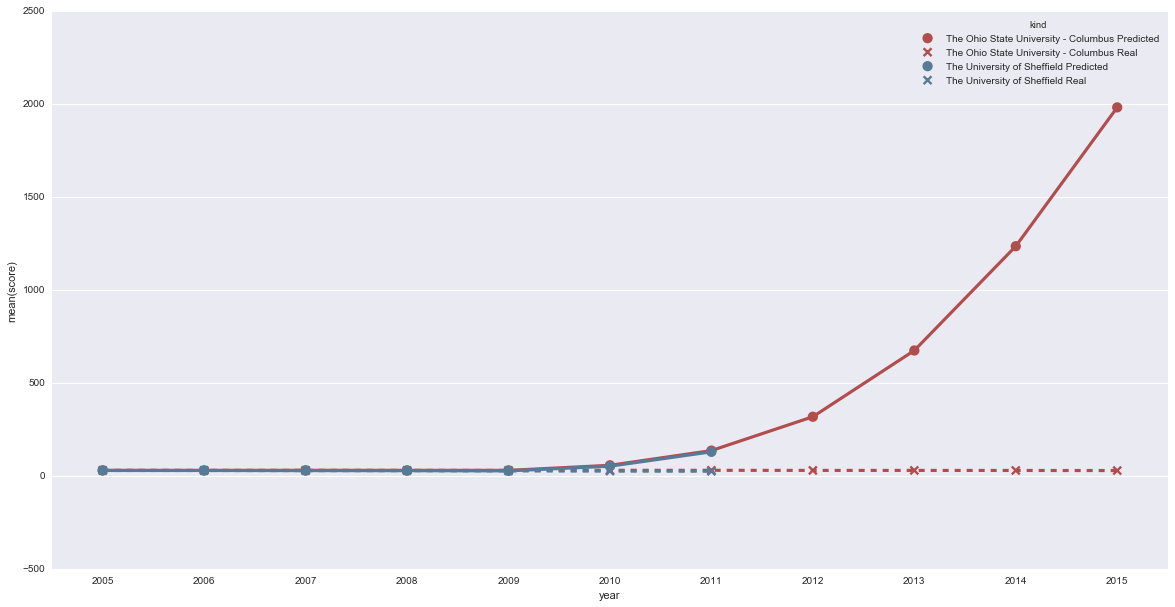

In [594]:
plot_scores_by_names(shanghai_data[51:53]['university_name'].values)